In [96]:
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import seaborn as sns
import datetime as dt
import cartopy.crs as ccrs

# plot settings
sns.set_theme()
%config InlineBackend.figure_format = "retina"
plt.rcParams["figure.dpi"] = 100

# map projection
# map projection
# grid_mapping = rotated_pole
# grid_mapping_name = rotated_latitude_longitude
# long_name = "coordinates of the rotated North Pole"
# grid_north_pole_latitude = 35.f
# grid_north_pole_longitude = -168.f
proj = ccrs.RotatedPole(pole_latitude=35, pole_longitude=-168)
trans = ccrs.PlateCarree()

# parameters
res = ["02", "05", "1"]

### Spatial domain

Total precipitation sum during simulation period

In [50]:
# import data
lon = {}
lat = {}
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_timsum.nc")
    lon[r] = f.variables["lon"][:]
    lat[r] = f.variables["lat"][:]
    totprec[r] = f.variables["tot_prec"][0,:,:]
    f.close()

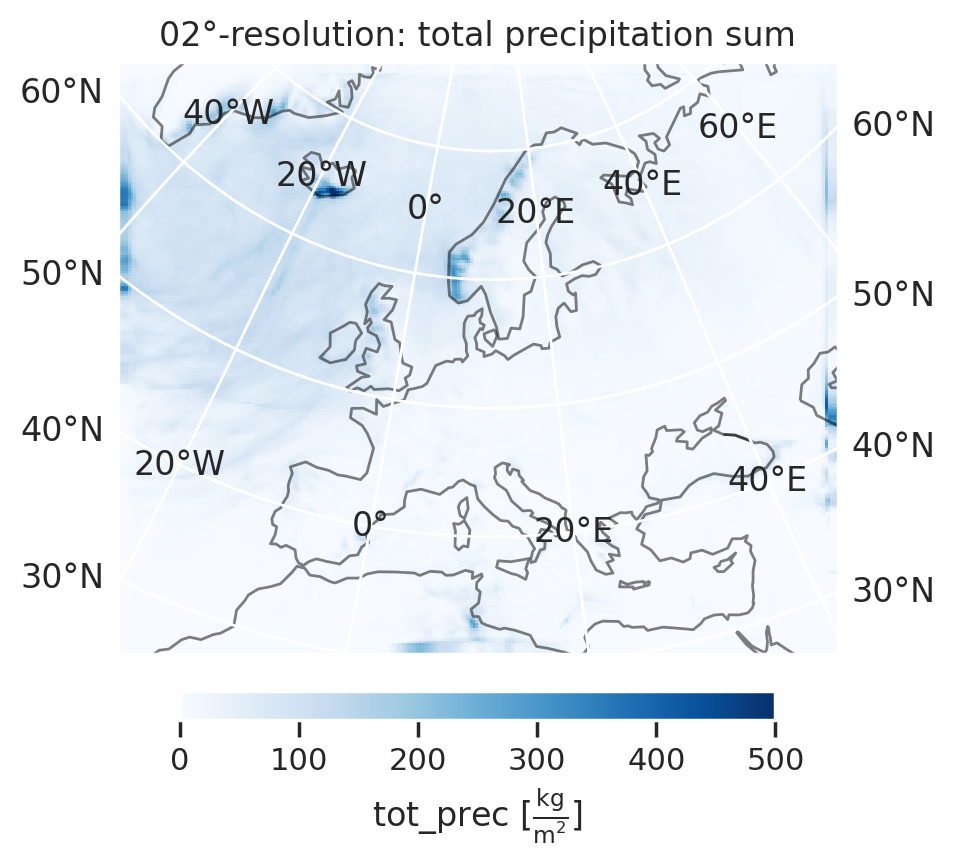

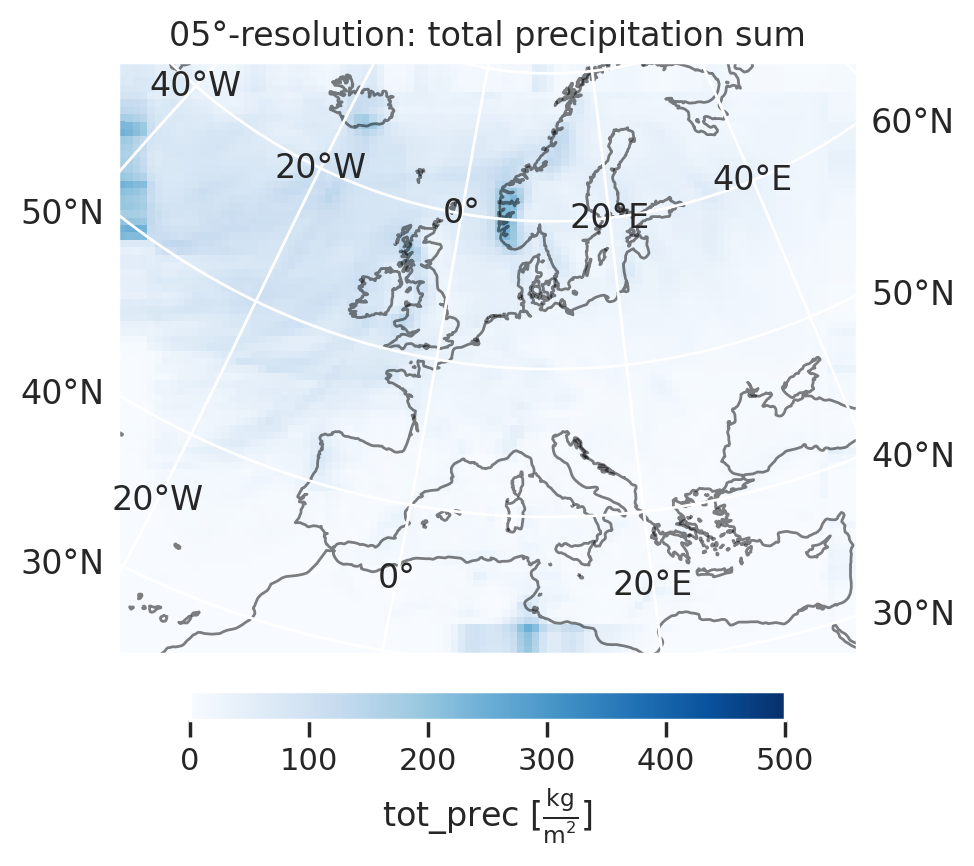

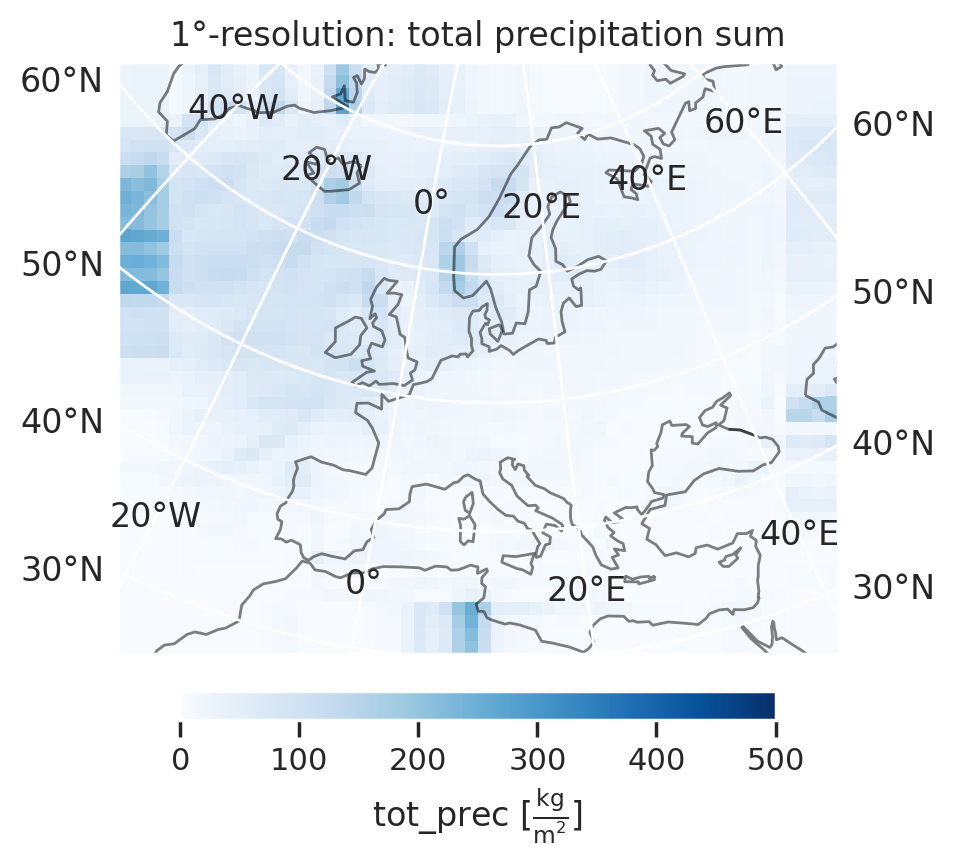

In [53]:
# plotting
for r in res:
    fig, ax = plt.subplots(subplot_kw=dict(projection = proj))
    cm = ax.pcolormesh(lon[r], lat[r], totprec[r], transform=trans, cmap="Blues", vmin=0, vmax=500)
    ax.coastlines(alpha=0.5)
    #ax.gridlines(draw_labels=True)
    ax.set_title(f"{r}°-resolution: total precipitation sum")
    cb = fig.colorbar(cm, orientation="horizontal", shrink=0.6, pad=0.05)
    cb.set_label(r"tot_prec [$\frac{\mathrm{kg}}{\mathrm{m^2}}$]")

- Mehr Niederschlag bei höherer Auflösung
- Artefakte am Rand (in der interpolation region?)
- Warum sind die Regionen nicht identisch im Ausmaß?

### Temporal domain

Daily precipitation sum within region of forecast

In [26]:
# RefTime =  1990-01-01 00:00:00  Units = seconds  Calendar = proleptic_gregorian
def convTime(tlist):
    tt = []
    for t in tlist:
        tt.append(dt.date(1990, 1, 1) + dt.timedelta(seconds=t))
    return tt

In [23]:
# import data
totprec = {}

for r in res:
    f = Dataset(f"../output/totprec_{r}deg_fldsum.nc")
    time = f.variables["time"][:]
    totprec[r] = f.variables["tot_prec"][:,0,0]
    f.close()

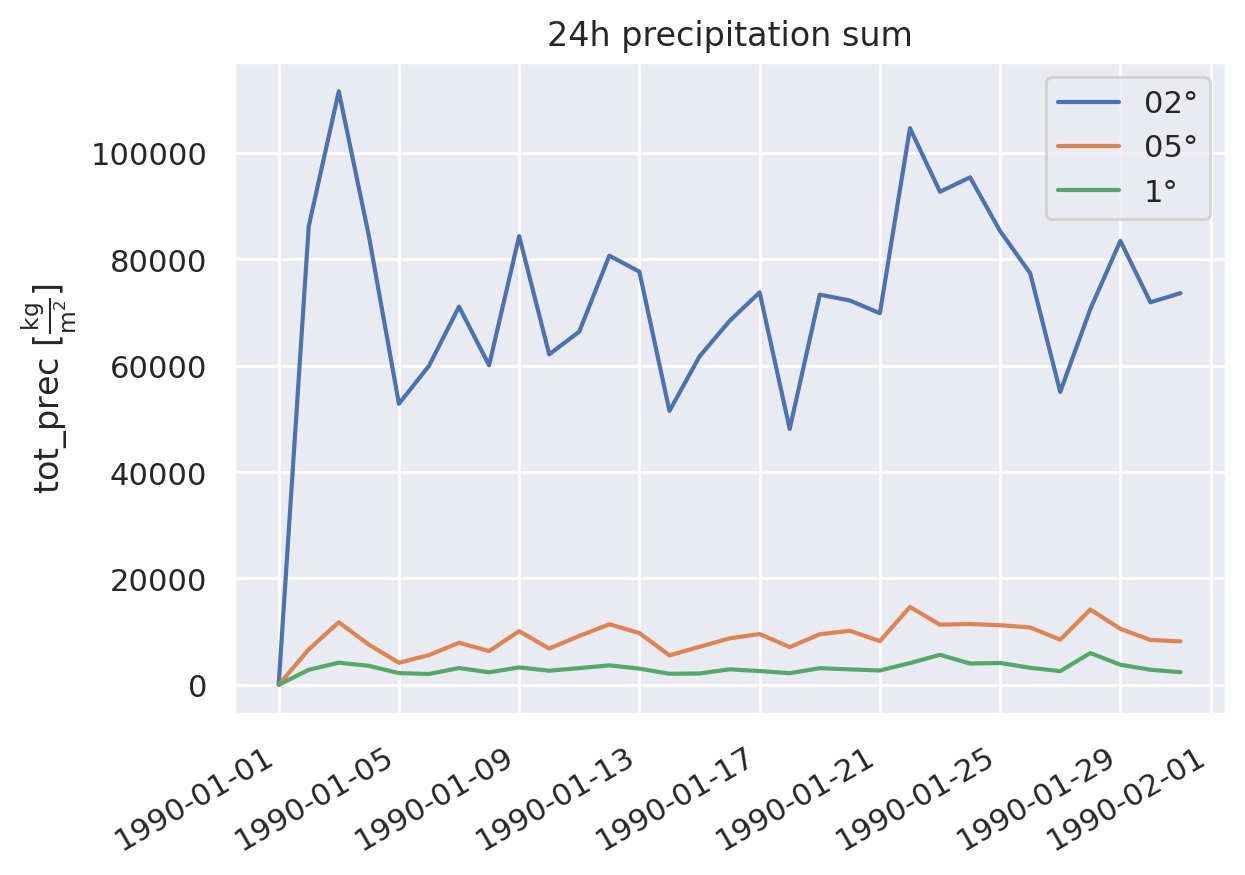

In [35]:
# plotting
fig, ax = plt.subplots()

for r in res:
    ax.plot(convTime(time), totprec[r], label=f"{r}°")
    
ax.legend()
ax.set_title("24h precipitation sum")
ax.set_ylabel(r"tot_prec [$\frac{\mathrm{kg}}{\mathrm{m^2}}$]")
fig.autofmt_xdate()

- lieber als bar plot?
- Trend zwischen Auflösungen gleich, aber absolute Werte **enorm** unterschiedlich
- Erster Tag ist zum Start der Simulation, also noch kein Niederschlag
- Picke Tage mit viel Niederschlag heraus

### Hovmöller diagram

In [124]:
# import data
rlon = {}
totprec_meri = {}

for r in res:
    f = Dataset(f"../simulations/europe-{r}deg/ANALYSIS/MERGED/out1_sfc.nc")
    time = convTime(f.variables["time"][:])
    rlon[r] = f.variables["rlon"][:]
    totprec = f.variables["tot_prec"][:]
    # calculate meridional sum (in rotated coordinates)
    totprec_meri[r] = np.sum(totprec, axis=1)
    f.close()

In [125]:
np.shape(totprec_meri[res[0]])

(31, 280)

In [126]:
np.shape(rlon[res[0]])

(280,)

In [127]:
np.shape(time)

(31,)

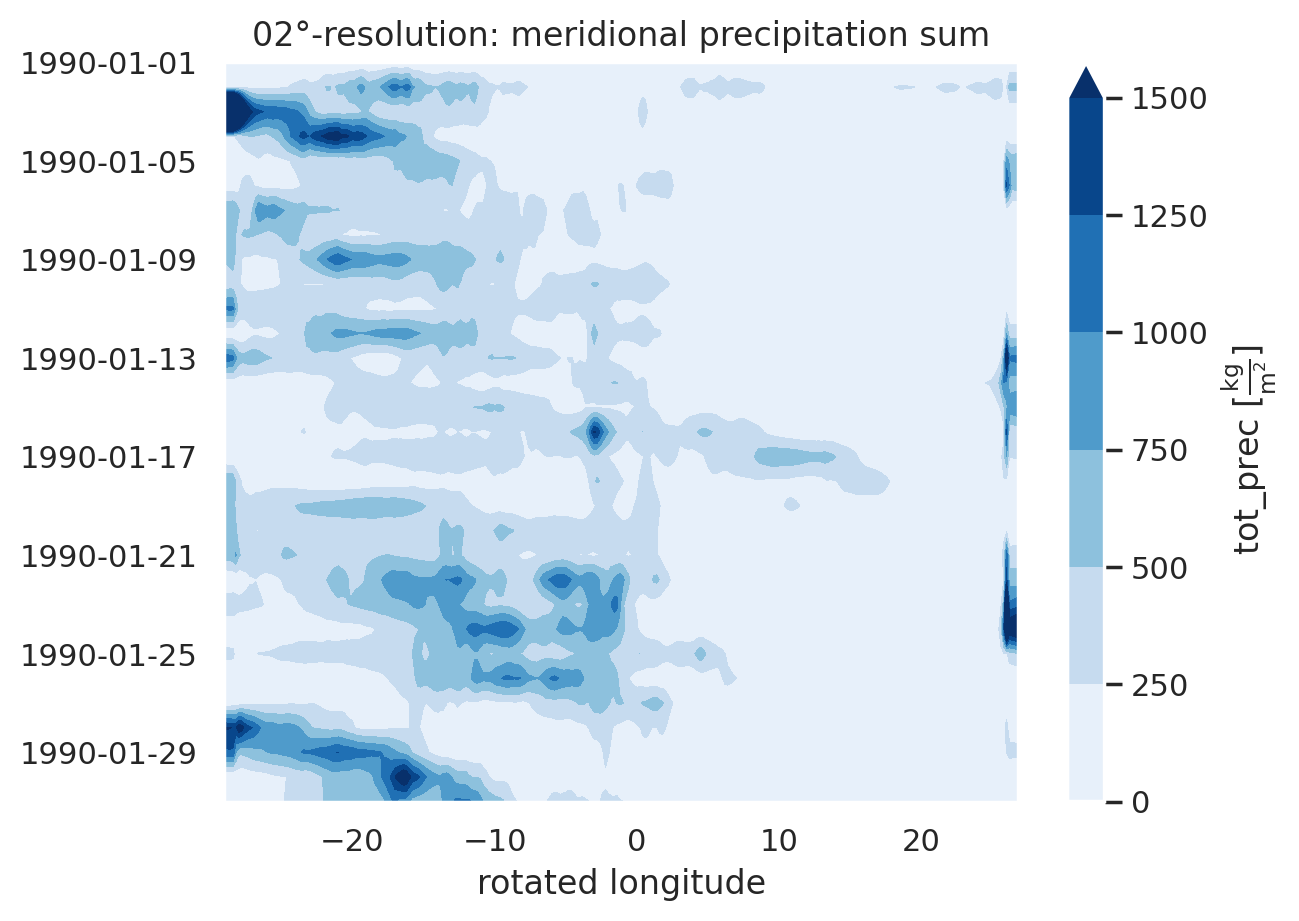

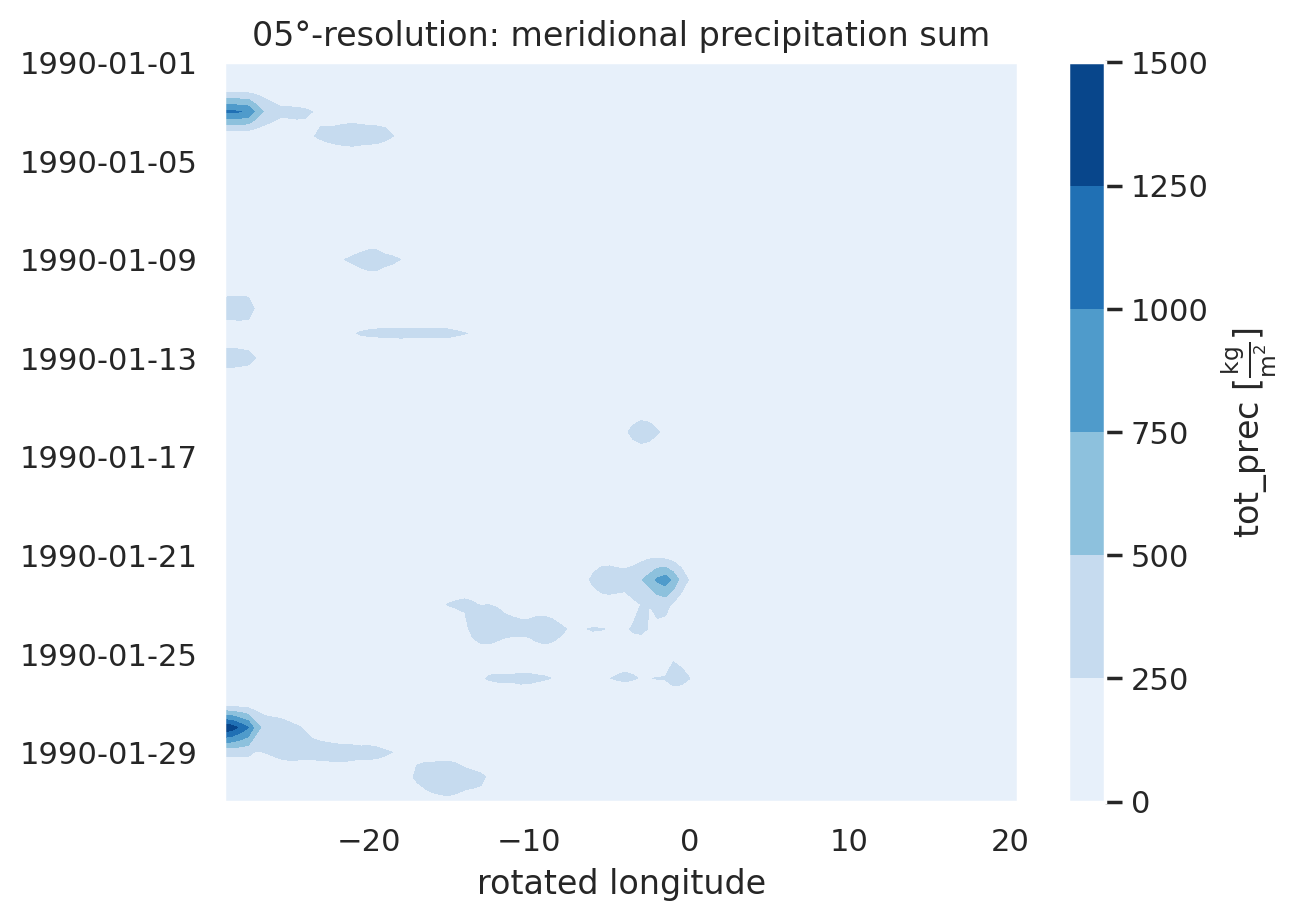

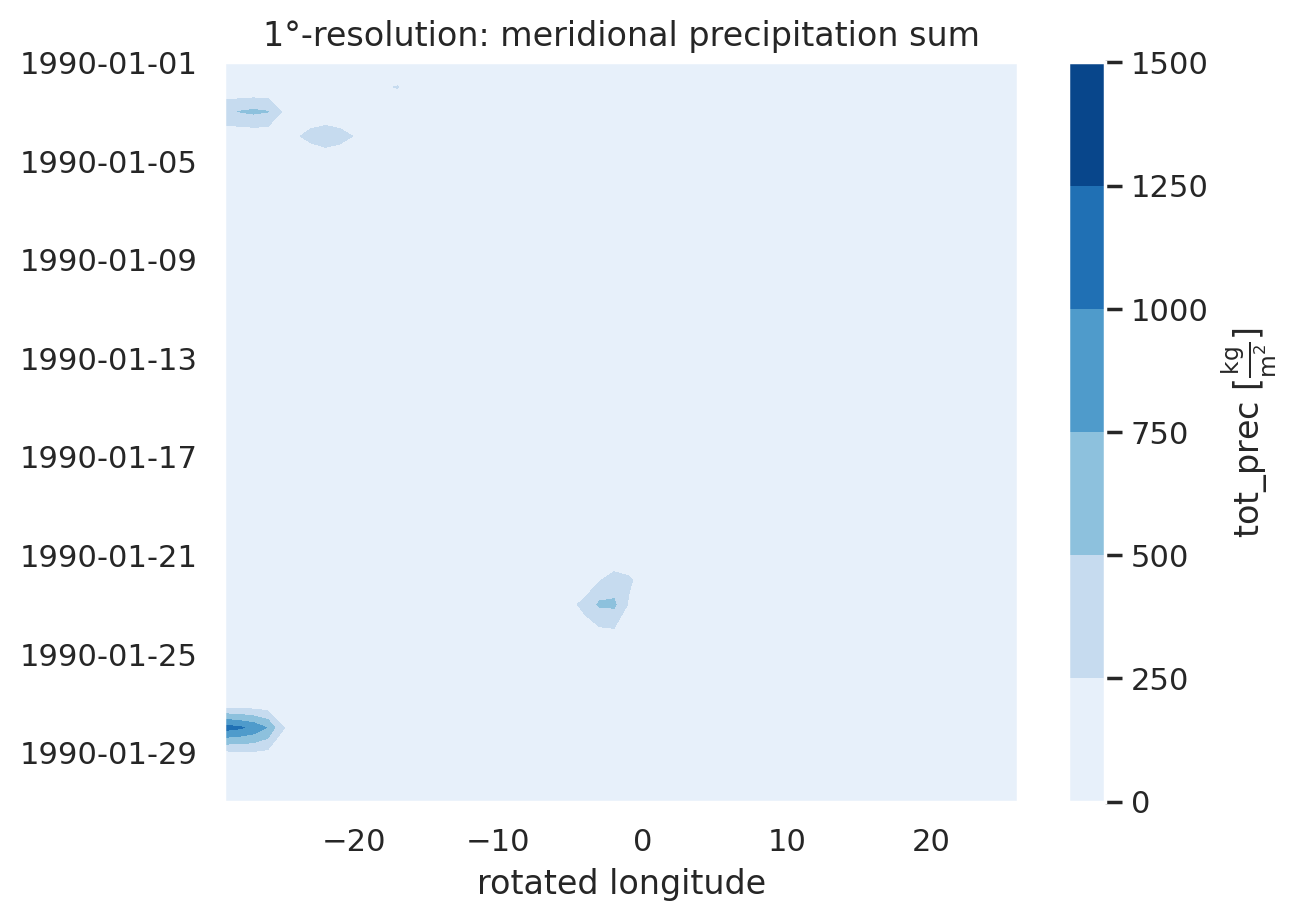

In [145]:
extend = ["max", None, None]

for r, e in zip(res, extend):
    xrlon, ytime = np.meshgrid(rlon[r], time)
    fig, ax = plt.subplots()
    cf = ax.contourf(xrlon, ytime, totprec_meri[r], cmap="Blues", levels=np.linspace(0,1500,7), extend=e)
    cb = fig.colorbar(cf)
    cb.set_label(r"tot_prec [$\frac{\mathrm{kg}}{\mathrm{m^2}}$]")
    ax.invert_yaxis()
    ax.set_xlabel("rotated longitude")
    ax.set_title(f"{r}°-resolution: meridional precipitation sum") 

- "hereinziehender" Regen aus boundary files geht verloren in Simulation
- vorherrschende Westströmung deutlich zu erkennen
- suche Ereignisse mit viel Regen raus und plotte Wetterkarte (?)